## <font color='green'>**GPT for 童話 ver3**</font>
**Written by Nakano & ChatGPT**

以下のコードは、Google Colab 上で実行することを想定した実装です。  
これは、中高校生が「言語モデル（GPT）」の構築を体験できるようにしたサンプルコードです。  
- 楠木正雄の童話10編を、現代語に編集したテキストを用いてモデルを学習します。  
  桃太郎、浦島太郎、一寸法師、舌切り雀、花咲か爺  
  文福茶釜、こぶとり爺さん、かちかち山、猿蟹合戦、かぐや姫
- 現代語への編集は、単なる言い換へではなく、原作の筋書きを活かしながら感情表現・描写・物語として深みを追加し、読みやすく再構成した作品といえる変換がおこなわれています。
- 学習中に、誤差（loss）の推移を可視化したり、モデルがどんな単語を予測するかを出力します。
- 学習が終わった後は、実際に文章を生成（続きを作る）できるようになっています。  


### <font color='green'>**Step1 ライブラリーのインストール**</font>

In [19]:
!pip install -Uq gcsfs==2023.9.2
!pip install -Uq fsspec==2023.9.2
!pip install -Uq datasets==3.2.0
!pip install -qq mecab-python3
!pip install -qq unidic-lite
!pip install -qq japanize_matplotlib
!pip install -qq beautifulsoup4
!pip install -q gdown

### <font color='green'>**Step2 ライブラリーのインポート**</font>

In [20]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

import MeCab
import unicodedata
import re
import gdown

from bs4 import BeautifulSoup  # HTMLからテキストだけ抜き出すのに使う
from datasets import load_dataset

# ここで乱数シードを固定する！
import random

SEED = 1  # 好きな整数を設定
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# GPUが使えるかどうかを自動判定（使えるならGPUを使う）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用デバイス:", device)

使用デバイス: cuda


### **<font color='green'>Step3 「童話」のダウンロードと前処理</font>**

In [21]:
# nakano.ryoichi.kakenのdrive上の'dowa10.txt'（共有ファイル）を読み込む
file_id = "10cCZyox3ET316DG2BYtnxdHwHoJZ2cxp"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, "corpus.txt", quiet=False)

# datasetsライブラリでテキストを読み込み
dataset = load_dataset("text", data_files={"train": 'corpus.txt'}, encoding="shift_jis")
dataset = dataset["train"]

# MeCabを使って日本語の文章を単語単位に分割（分かち書き）する
mecab = MeCab.Tagger("-Owakati")

def tokenize_japanese(text):
    return mecab.parse(text).strip().split()

# 全部の行を読み込み、単語リストを作成
text_list = []
for d in dataset:
    line = d["text"].strip()
    if len(line) == 0:
        continue
    tokens = tokenize_japanese(line)
    text_list.extend(tokens)

# 小説の冒頭にある「見出し」を削除して、本文だけにする（手動で範囲指定）
text_list = text_list[8:]

# 小説末尾付近の不要箇所を削除（こちらも手動で範囲指定）
# text_list = text_list[:6453]

print("トークン総数:", len(text_list))
print("サンプル:", text_list[:50])

Downloading...
From: https://drive.google.com/uc?id=10cCZyox3ET316DG2BYtnxdHwHoJZ2cxp
To: /content/corpus.txt
100%|██████████| 54.5k/54.5k [00:00<00:00, 83.5MB/s]


トークン総数: 17267
サンプル: ['家', 'に', '暮らす', 'お', 'じい', 'さん', 'と', 'お', 'ばあ', 'さん', 'が', 'い', 'た', '。', 'ふたり', 'は', '長い', 'あいだ', '連れ添い', '、', 'お', '互い', 'を', '思いやり', 'ながら', '慎ましく', '生き', 'て', 'い', 'た', 'が', '、', '子ども', 'に', 'は', '恵まれ', 'なかっ', 'た', '。', 'それ', 'で', 'も', 'お', 'じい', 'さん', 'は', '「', 'ふたり', 'で', '生き']


### <font color='green'>**Step4 ハイパーパラメータの設定**</font>

In [22]:
context_size = 10   # 学習時に、一度に見る単語（コンテキスト）の数
d_model = 128        # 単語を何次元のベクトルで表すか（埋め込み次元）
n_head = 4          # Multi-Head Attentionのヘッド数（並行してみる視点）
n_block = 4         # デコーダブロックを何層積み重ねるか
batch_size = 64     # バッチサイズ（1度のパラメータ更新で使うサンプル数）
epoch_num = 30      # 何回サンプルを繰り返し学習するか

### <font color='green'>**Step5 語彙の作成**</font>

In [23]:
from collections import Counter

# 単語をIDに変換するための辞書を作る
special_tokens = ["<PAD>", "<BOS>", "<EOS>"]
word2id = {}
id2word = {}

# テキスト中に出現するユニークな単語を取り出し、
# special tokens を先頭に付与して「vocab(語彙)」とする。
# unique_tokens = list(set(text_list))
# vocab = special_tokens + unique_tokens

# 単語の出現頻度を数えて、頻度順にソート
word_counts = Counter(text_list)
sorted_vocab = [w for w, _ in word_counts.most_common()]

# special tokens を追加
vocab = special_tokens + sorted_vocab

# 語彙表を作成
for i, w in enumerate(vocab):
    word2id[w] = i
    id2word[i] = w

vocab_size = len(vocab)
print("語彙数:", vocab_size)

# 文章を数字（ID）の列に変換
encoded_text = [word2id[w] for w in text_list if w in word2id]

語彙数: 2182


### <font color='green'>**Step6 学習データ（入力と正解）の作成**</font>

In [24]:
# 連続する単語を15個見て、次の1単語を予測する形のデータを用意
dataX = []
dataY = []

# augmented_text_listには、「メロス」周辺を3倍にした文章が入っている
for i in range(len(text_list) - context_size):
    # 入力となる15単語
    x = [word2id[w] for w in text_list[i : i + context_size]]
    # 正解となる次の1単語
    y = word2id[text_list[i + context_size]]

    dataX.append(x)
    dataY.append(y)

dataX = np.array(dataX)
dataY = np.array(dataY)

# 学習を安定させるため、データをシャッフル（順番をランダム化）
indices = np.arange(len(dataX))
np.random.shuffle(indices)

dataX = dataX[indices]
dataY = dataY[indices]

# 学習データをTensorに変換（PyTorchで扱うため）
dataX_torch = torch.tensor(dataX, dtype=torch.long)
dataY_torch = torch.tensor(dataY, dtype=torch.long)

print("学習用サンプル数:", len(dataX_torch))

学習用サンプル数: 17257


### <font color='green'>**Step7 モデルの定義**</font>

In [25]:
# ---- 7.1 Attention の定義 ----
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        assert d_model % n_head == 0  # ヘッドごとの次元数が割り切れる前提

        self.d_model = d_model
        self.n_head = n_head
        self.d_head = d_model // n_head  # 1ヘッドあたりの埋め込み次元数

        # Q, K, V を求めるための線形変換（重み）
        self.W_Q = nn.Linear(d_model, d_model, bias=False)
        self.W_K = nn.Linear(d_model, d_model, bias=False)
        self.W_V = nn.Linear(d_model, d_model, bias=False)

        # 最後にヘッドを結合した後の出力変換
        self.W_O = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, mask=None):
        """
        x: (batch_size, seq_len, d_model)
        mask: 将来の情報を見ないようにするためのマスク
        """

        B, T, _ = x.size()

        # Q, K, V を計算
        Q = self.W_Q(x)  # (B, T, d_model)
        K = self.W_K(x)  # (B, T, d_model)
        V = self.W_V(x)  # (B, T, d_model)

        # 形状を (B, n_head, T, d_head) に変換してから、アテンション計算
        Q = Q.view(B, T, self.n_head, self.d_head).transpose(1, 2)
        K = K.view(B, T, self.n_head, self.d_head).transpose(1, 2)
        V = V.view(B, T, self.n_head, self.d_head).transpose(1, 2)

        # スケーリング付きドット積アテンション
        # QとKの内積を取って、重要度を計算する
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_head)

        # マスクがあれば、未来のトークンを見ないように -inf にする
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))

        # ソフトマックスで確率分布にしてから、Vを重み付き平均
        attn_weights = F.softmax(scores, dim=-1)
        out = torch.matmul(attn_weights, V)

        # 形状を元に戻して、最後の線形変換
        out = out.transpose(1, 2).contiguous().view(B, T, self.d_model)
        out = self.W_O(out)  # (B, T, d_model)

        return out

# ---- 7.2 FeedForward の定義 ----
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim=256):
        super().__init__()
        # 線形層→ReLU→線形層のシンプルな構成
        self.fc1 = nn.Linear(d_model, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, d_model)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# ---- 7.3 DecoderBlock (TransformerDecoderLayerに相当) の定義 ----
class DecoderBlock(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        # self attention
        self.self_attn = MultiHeadSelfAttention(d_model, n_head)
        self.norm1 = nn.LayerNorm(d_model)

        self.ff = PositionwiseFeedForward(d_model, hidden_dim=4*d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Self-Attention
        attn_out = self.self_attn(x, mask=mask)
        x = self.norm1(x + attn_out)  # Residual + LayerNorm

        # FeedForward
        ff_out = self.ff(x)
        # 残差接続 + LayerNorm
        x = self.norm2(x + ff_out)

        return x

# ---- 7.4 GPTモデル (Decoderの積み重ね部分) の定義 ----
class GPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_head, n_block, max_len=512):
        super().__init__()
        self.d_model = d_model

        # 語彙サイズ(vocab_size)×埋め込み次元(d_model)の埋め込み行列
        self.embed_tokens = nn.Embedding(vocab_size, d_model)
        # 位置情報を埋め込む行列
        self.pos_embedding = nn.Embedding(max_len, d_model)

        # 語彙埋め込み層（Embedding）の初期化を変更
        # nn.init.normal_(self.embed_tokens.weight, mean=0, std=0.02)
        # 語彙埋め込みの初期化
        nn.init.xavier_uniform_(self.embed_tokens.weight)

        # デコーダブロックを複数積む
        self.blocks = nn.ModuleList([
            DecoderBlock(d_model, n_head) for _ in range(n_block)
        ])

        # 最後のLayerNorm
        self.ln_f = nn.LayerNorm(d_model)
        # 出力層：単語の確率を出す（logits）
        # self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.head = nn.Linear(d_model, vocab_size, bias=True)  # bias=False → True に変更

    def forward(self, x):
        """
        x: (batch_size, seq_len)
        戻り値: (batch_size, seq_len, vocab_size)
        """

        B, T = x.shape

        # 単語埋め込み
        token_emb = self.embed_tokens(x)  # (B, T, d_model)

        # 位置埋め込み
        positions = torch.arange(0, T, dtype=torch.long, device=x.device).unsqueeze(0)  # (1, T)
        pos_emb = self.pos_embedding(positions)  # (1, T, d_model)

        # 埋め込みを足し合わせ
        h = token_emb + pos_emb  # (B, T, d_model)

        # 将来の単語を参照しないようにするマスク(下三角マスク)
        causal_mask = torch.tril(torch.ones(T, T, device=x.device)).unsqueeze(0).unsqueeze(0)

        # デコーダブロックを順番に通過
        for block in self.blocks:
            h = block(h, mask=causal_mask)

        # 最後にLayerNorm
        h = self.ln_f(h)

        # 出力（各時刻ごとにvocab_size次元のスコア）
        logits = self.head(h)  # (B, T, vocab_size)

        return logits

### <font color='green'>**Step8 学習**</font>

/tmp/ipython-input-1696489184.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)
/tmp/ipython-input-1696489184.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp, dtype=torch.float16):


=== 繰り返し回数 1 ===
  誤差: 6.0610
  入力単語列　: を 見 て いる うち に 、 ふっ と 笑い
  予測した単語: 。
  正解の単語　: が 

=== 繰り返し回数 2 ===
  誤差: 5.5411
  入力単語列　: ちょこん と 横 に 座っ て い た 。 ある
  予測した単語: た
  正解の単語　: 朝 

=== 繰り返し回数 3 ===
  誤差: 4.9608
  入力単語列　: に 吠える の で 、 その 場所 を 掘っ て
  予測した単語: い
  正解の単語　: みる 

=== 繰り返し回数 4 ===
  誤差: 4.3044
  入力単語列　: だ 。 やがて 鬼 たち が 現れ 、 昨日 と
  予測した単語: 、
  正解の単語　: 同じ 

=== 繰り返し回数 5 ===
  誤差: 3.9643
  入力単語列　: て き た の だ 。 お じい さん も
  予測した単語: 、
  正解の単語　: お 

=== 繰り返し回数 6 ===
  誤差: 3.7380
  入力単語列　: つい て 回っ た 。 お じい さん が 薪
  予測した単語: を
  正解の単語　: を 

=== 繰り返し回数 7 ===
  誤差: 3.5698
  入力単語列　: ばあ さん の 目 は ごまかせ なかっ た 。 「
  予測した単語: お
  正解の単語　: お前 

=== 繰り返し回数 8 ===
  誤差: 3.4293
  入力単語列　: は そっと 犬 を 抱き上げ 、 家 へ 連れ て
  予測した単語: い
  正解の単語　: 帰っ 

=== 繰り返し回数 9 ===
  誤差: 3.3262
  入力単語列　: て も 、 光 を まとっ た 使者 に は
  予測した単語: 、
  正解の単語　: 触れる 

=== 繰り返し回数 10 ===
  誤差: 3.2385
  入力単語列　: 並ん で い た 。 海 の 幸 を ふんだん
  予測した単語: に
  正解の単語　: に 



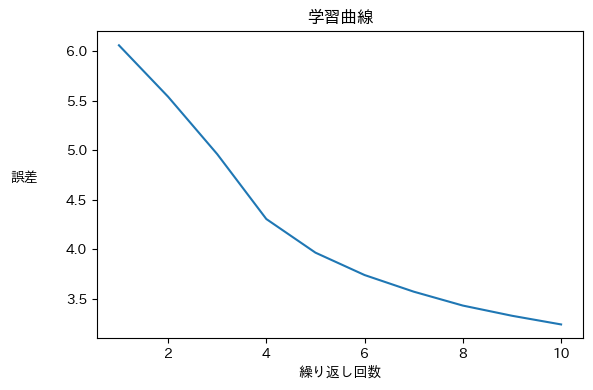

=== 繰り返し回数 11 ===
  誤差: 3.1543
  入力単語列　: 修繕 も できよう 。 」 和尚 さま が 戸惑っ て
  予測した単語: い
  正解の単語　: いる 

=== 繰り返し回数 12 ===
  誤差: 3.0849
  入力単語列　: ゆき 。 」 和尚 さま は そう 言っ て 狸
  予測した単語: は
  正解の単語　: を 

=== 繰り返し回数 13 ===
  誤差: 3.0254
  入力単語列　: 、 ほんとう に こぶ が 取れ た ん だ ねえ
  予測した単語: ！
  正解の単語　: ！ 

=== 繰り返し回数 14 ===
  誤差: 2.9703
  入力単語列　: 朝 、 ポチ が 庭 で 突然 吠え だし た
  予測した単語: 。
  正解の単語　: 。 

=== 繰り返し回数 15 ===
  誤差: 2.9205
  入力単語列　: なん と かわいそう に 。 誰 が こんな 罠 を
  予測した単語: 見
  正解の単語　: … 

=== 繰り返し回数 16 ===
  誤差: 2.8778
  入力単語列　: 人々 に 愛さ れ て い た 。 ある 日
  予測した単語: の
  正解の単語　: 、 

=== 繰り返し回数 17 ===
  誤差: 2.8383
  入力単語列　: 貧乏 夫婦 ばかり 良い 思い を する ん だ 」
  予測した単語: と
  正解の単語　: 「 

=== 繰り返し回数 18 ===
  誤差: 2.8033
  入力単語列　: わし の 目 が おかしく なっ た の か ？
  予測した単語: 」
  正解の単語　: 」 

=== 繰り返し回数 19 ===
  誤差: 2.7722
  入力単語列　: と 燃え上がっ た 。 「 ぎゃあ あああ ああ ！ 」
  予測した単語: お
  正解の単語　: 狸 

=== 繰り返し回数 20 ===
  誤差: 2.7428
  入力単語列　: 影 に 身 を 隠し た 。 鬼 たち は
  予測した単語: 、
  正解の単語　: 丸太 



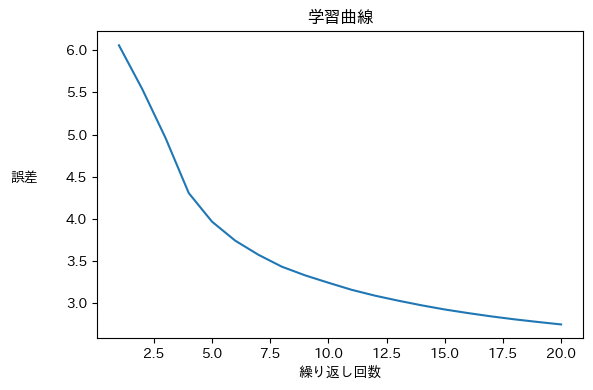

=== 繰り返し回数 21 ===
  誤差: 2.7145
  入力単語列　: お ばあ さん も 驚き の あまり 、 しばらく 声
  予測した単語: を
  正解の単語　: が 

=== 繰り返し回数 22 ===
  誤差: 2.6887
  入力単語列　: 「 私 は この世 の 人間 と は 、 どこ
  予測した単語: か
  正解の単語　: か 

=== 繰り返し回数 23 ===
  誤差: 2.6654
  入力単語列　: 温かく 迎え た 。 お じい さん は 座敷 に
  予測した単語: 、
  正解の単語　: 通さ 

=== 繰り返し回数 24 ===
  誤差: 2.6446
  入力単語列　: に し た 。 すずめ たち は お じい さん
  予測した単語: は
  正解の単語　: の 

=== 繰り返し回数 25 ===
  誤差: 2.6264
  入力単語列　: に 、 鳥 まで 養う の か い ？ 」
  予測した単語: と
  正解の単語　: しかし 

=== 繰り返し回数 26 ===
  誤差: 2.6114
  入力単語列　: た 。 その 後 、 木 の 上 から さる
  予測した単語: 、
  正解の単語　: が 

=== 繰り返し回数 27 ===
  誤差: 2.5997
  入力単語列　: と お ばあ さん が い た 。 ふたり は
  予測した単語: 、
  正解の単語　: 長い 

=== 繰り返し回数 28 ===
  誤差: 2.5893
  入力単語列　: 瞬間 、 帝 は 息 を 呑ん だ 。 「
  予測した単語: お
  正解の単語　: これ 

=== 繰り返し回数 29 ===
  誤差: 2.5808
  入力単語列　: 行っ た 。 季節 は めぐり 、 夏 が 終わりかけ
  予測した単語: た
  正解の単語　: た 

=== 繰り返し回数 30 ===
  誤差: 2.5734
  入力単語列　: 。 器 は 素朴 だ が 美しく 、 どれ も
  予測した単語: 、
  正解の単語　: 心 



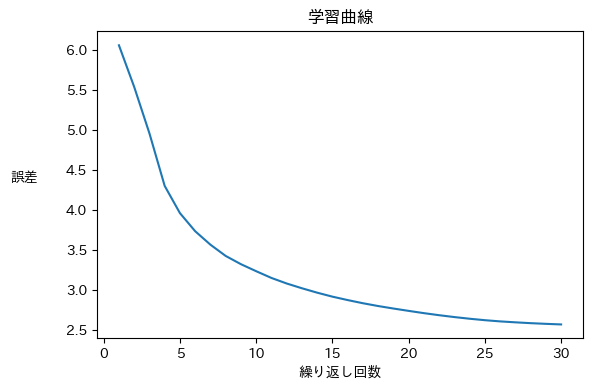

In [26]:
# AMPの準備
from torch.cuda.amp import autocast, GradScaler
import subprocess, textwrap

use_amp = (device.type=="cuda")
scaler = GradScaler(enabled=use_amp)

# モデルを作る
model = GPT(vocab_size, d_model, n_head, n_block).to(device)

# オプティマイザ（重みを更新する仕組み）と学習率スケジューラを設定
optimizer = optim.Adam(model.parameters(), lr=1.5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=epoch_num,
    eta_min=1e-5
)

def calculate_weighted_loss(logits, target, context):
    """
    logits: モデル出力 (batch_size, vocab_size)
    target: 正解ID (batch_size,)
    context: 入力(どの単語列を見て予測したか)
    """
    logits_fp32 = logits.float()
    target = target.long()

    # 通常のクロスエントロピーを計算(reduction='none'で個々の要素のロスをとる)
    base_loss = F.cross_entropy(logits_fp32, target, reduction='none')

    return base_loss.mean()

# 学習曲線を記録するリスト
losses = []

# 学習用データをバッチに分けて返す関数
def get_batches(X, Y, batch_size):
    for i in range(0, len(X), batch_size):
        x_batch = X[i:i+batch_size]
        y_batch = Y[i:i+batch_size]
        yield x_batch, y_batch

model.train()  # 学習モード
for epoch in range(1, epoch_num+1):
    total_loss = 0.0
    count = 0

    # バッチごとに学習
    for x_batch, y_batch in get_batches(dataX_torch, dataY_torch, batch_size):
        x_batch = x_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)

        # 勾配リセット　ー＞　逆伝播
        optimizer.zero_grad()

        # 混合精度の順伝播
        with autocast(enabled=use_amp, dtype=torch.float16):
            logits = model(x_batch)
            last_token_logits = logits[:, -1, :]
            loss = calculate_weighted_loss(
                last_token_logits,
                y_batch,
                x_batch
            )

        # 逆伝播(スケーリング付き)
        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.detach()
        count += 1

    # 学習率をスケジューラで変化させる
    scheduler.step()

    epoch_loss = (total_loss / max(count, 1)).float().cpu().item()
    losses.append(epoch_loss)

    # ============
    # 途中経過の確認
    # ============
    # ここでは epoch 毎に1サンプルを拾い、モデルがどんな単語を予測するか確認します。
    sample_idx = np.random.randint(0, len(dataX_torch))
    sample_input_ids = dataX_torch[sample_idx].unsqueeze(0).to(device)  # (1, context_size)

    target_id = dataY_torch[sample_idx].item()
    with torch.no_grad():
        out_logits = model(sample_input_ids)
        pred_id = out_logits[:, -1, :].argmax(dim=-1).item()

    input_words = [id2word[i.item()] for i in sample_input_ids[0]]
    pred_word = id2word[pred_id]
    target_word = id2word[target_id]

    print(f"=== 繰り返し回数 {epoch} ===")
    print(f"  誤差: {epoch_loss:.4f}")
    print(f"  入力単語列　: {' '.join(input_words)}")
    print(f"  \033[31m予測した単語: {pred_word}")
    print(f"  正解の単語　: {target_word}",  '\033[0m')
    print()

    # 10エポックごとに学習曲線を表示
    if epoch % 10 == 0:
        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot(1,1,1)
        ax.plot(range(1, epoch+1), losses, label="Training Loss")
        ax.set_xlabel("繰り返し回数")
        ax.set_ylabel("誤差", rotation=0)
        ax.yaxis.set_label_coords(-0.15, 0.5)
        plt.title("学習曲線")
        fig.tight_layout()    #文字が重ならないよう調整
        plt.show()


### <font color='green'>**Step9 生成テストのための関数の定義**</font>

In [27]:
def generate_text_with_temp(model, start_text, max_new_tokens=30, temperature=0.7):
    """
    start_text: 文章生成の開始文
    max_new_tokens: 何単語分生成するか
    temperature: 温度(0に近いほど確実な単語を選択, 大きいほどランダム性高い)
    """
    model.eval()
    # 文章を単語に分割
    start_tokens = tokenize_japanese(start_text)

    # 単語→IDに変換
    input_ids = [word2id[t] for t in start_tokens if t in word2id]

    if not input_ids: # If start_text is empty or contains only unknown words
        input_ids = [word2id["<BOS>"]] # Start with BOS token

    # The actual sequence that will be outputted, starting with the processed input_ids
    full_output_ids = list(input_ids)

    # Prepare the initial model input buffer to be context_size long
    model_input_buffer_list = list(input_ids)
    if len(model_input_buffer_list) < context_size:
        # Pad with <PAD> tokens at the beginning to reach context_size
        padding_needed = context_size - len(model_input_buffer_list)
        model_input_buffer_list = [word2id["<PAD>"]] * padding_needed + model_input_buffer_list
    elif len(model_input_buffer_list) > context_size:
        # Truncate from the beginning to keep only the last context_size tokens
        model_input_buffer_list = model_input_buffer_list[-context_size:]
    else:
        model_input_buffer_list = input_ids

    # Convert the buffer to a tensor for the model
    model_input_tensor = torch.tensor(model_input_buffer_list, dtype=torch.long, device=device).unsqueeze(0)

    for _ in range(max_new_tokens):
        with torch.no_grad():
            # Model prediction: The model always receives a context_size long sequence
            logits = model(model_input_tensor)  # (1, context_size, vocab_size)

            # Get logits for the next token, which is predicted from the last position of the input
            last_logits = logits[:, -1, :] / temperature

            # Apply softmax to get probability distribution
            probs = F.softmax(last_logits, dim=-1)

            # Sample the next word probabilistically
            next_id = torch.multinomial(probs[0], 1).item()

            # Add the new token to the full output sequence
            full_output_ids.append(next_id)

            # Update the model_input_buffer_list by removing the oldest token and adding the new one
            model_input_buffer_list = model_input_buffer_list[1:] + [next_id]
            model_input_tensor = torch.tensor(model_input_buffer_list, dtype=torch.long, device=device).unsqueeze(0)

            # Stop if EOS token is generated
            if id2word[next_id] == "<EOS>":
                break

    # Convert ID sequence to words for the final output
    output_words = [id2word[idx] for idx in full_output_ids]
    return "".join(output_words)


### <font color='green'>**Step10 生成テスト**</font>

In [30]:
# 例: 「おじいさん」を開始文として生成してみる
#@title 開始文の指定
prompt = 'おじいさんは'  #@param {type:'string'}
result = generate_text_with_temp(model, prompt, temperature=0.5)
print(result)

おじいさんとおばあさんは、「ポチのようだった。「おじいさんは、おばあさんと、おにぎりを送った。「まあ、おばあ
